In [1]:
from sklearn import datasets
from scipy.stats import ttest_ind

## One tailed t-test

We will use `diabetes` for an example. The target is a "quantitative measure of disease progression one year after baseline" We will examine if there is a difference in the target based of off `sex`.

In [2]:
dataset = datasets.load_diabetes(as_frame=True, scaled=False)
df = dataset.frame
df.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,59.0,2.0,32.1,101.0,157.0,93.2,38.0,4.0,4.8598,87.0,151.0
1,48.0,1.0,21.6,87.0,183.0,103.2,70.0,3.0,3.8918,69.0,75.0
2,72.0,2.0,30.5,93.0,156.0,93.6,41.0,4.0,4.6728,85.0,141.0
3,24.0,1.0,25.3,84.0,198.0,131.4,40.0,5.0,4.8903,89.0,206.0
4,50.0,1.0,23.0,101.0,192.0,125.4,52.0,4.0,4.2905,80.0,135.0


Let's create a boxplot to show the difference in the target by `sex`.

<Axes: title={'center': 'target'}, xlabel='sex'>

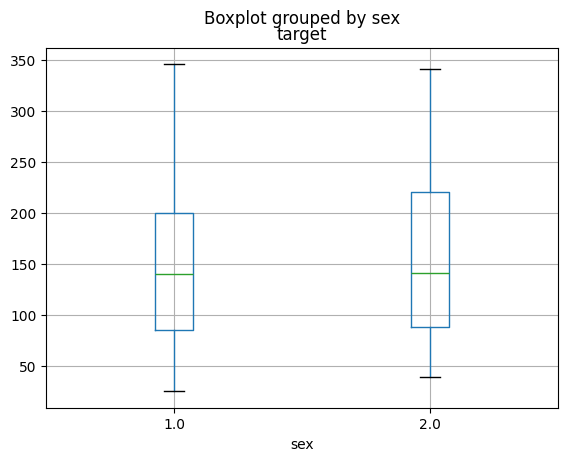

In [3]:
df.boxplot(column="target", by="sex")

Both boxes are very similar, however the box for sex `1` looks like it has slightly lower values (As seen by Q1 and Q3). 

Out of curisoity, let's see some simple stats for each `sex` value.

In [4]:
df.groupby("sex")["target"].describe()

,count,mean,std,min,25%,50%,75%,max
sex,,,,,,,,
1.0,235.0,149.021277,75.905781,25.0,85.5,140.0,200.0,346.0
2.0,207.0,155.666667,78.453313,39.0,88.0,141.0,220.5,341.0


The table above does show that the mean for sex `1` is slightly lower than sex `0`. This raises, the question, is this difference statistically significant?

We now have two groups, in which we want to check that the mean in one is **strictly lower** than the mean in the other. This is a perfect scenario for using a **one tailed t-test** to verify this. We can formulate the above problem thus:

**Hypotheses**
- Null N0: µ1 >= µ2 (Group 1 has the same or higher average `target` value)
- Alternative Na: µ1 < µ2 (Group 1 has a lower average `target` value)

We shall use an alpha value of 0.05 to determine significance, as it represents a 5% risk of concluding that a difference exists when there is none (Type I error). This is a commonly accepted threshold in hypothesis testing

In [9]:
alpha = 0.05

Create the groups for each `sex` value.

In [5]:
group_1 = df[df["sex"] == 1]["target"]
group_2 = df[df["sex"] == 2]["target"]

Use `scipy` to perform a two-tailed t-test. Scipy's `ttest_ind` returns two values:
1. `t-statistic`: How far the sample means are, relative to the variability in the data (larger = more significance)
2. `pvalue`: Probability in oberserving a difference at least as large as the one seen in the data

In [6]:
t_stat, p_two_tailed = ttest_ind(group_2, group_1, equal_var=False)

As we want to perform a one-tailed t-test, we need to divide the `p` value by two.

In [7]:
p_one_tailed = p_two_tailed / 2

We can now examine the results:

In [8]:
print(f"t-statistic: {t_stat:.4f}")
print(f"One-tailed p-value: {p_one_tailed:.4f}")

t-statistic: 0.9022
One-tailed p-value: 0.1837


Considering the above results:
- A *t-statistic* value of 0.9022 suggests that the groups means are less than 1 standard error apart. This is not strong evidence that there is a difference.
- A *p-value* of 0.1837 is larger than our alpha of 0.05

In conclusion, based off of the above one-tailed t-test we **fail** to reject the **null** hypothesis as there is insignificant evidence to conclude that a sex of `1` results in a lower `target` value than a sex of `2`.